In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from astropy.table import Table

In [3]:
radial_comp_all = np.load('CUT_deep_catalogs/completeness_14.npy')
radial_comp_sf = np.load('CUT_deep_catalogs/completeness_14_sf.npy')
radial_comp_q = np.load('CUT_deep_catalogs/completeness_14_q.npy')


bin_edges_comp = np.load('CUT_deep_catalogs/bin_edges.npy')
path = 'CUT_deep_catalogs/split_sat_mass/'
bin_edges = np.load(path+'bin_edges.npy')
correction_all = np.interp(bin_edges_comp[:-1],bin_edges_comp[:-1],radial_comp_all)
correction_sf = np.interp(bin_edges_comp[:-1],bin_edges_comp[:-1],radial_comp_sf)
correction_q = np.interp(bin_edges_comp[:-1],bin_edges_comp[:-1],radial_comp_q)

print(correction_all)
print(correction_sf)
print(correction_q)

[0.234375   0.46835443 0.59911894 0.76923077 0.83380282 0.85134037
 0.87338262 0.87536162 0.89565685 0.89276476 0.89318772 0.90114379
 0.89910365 0.90115982]
[0.19298246 0.36363636 0.55172414 0.73458445 0.81661442 0.83699634
 0.86167447 0.8669859  0.88786598 0.88371134 0.88383678 0.89241529
 0.89044906 0.89242616]
[0.57142857 1.         1.         1.         0.98611111 0.96402878
 0.96680498 0.9562982  0.95930949 0.97083926 0.97412779 0.97869
 0.97536042 0.97788736]


In [25]:
def comp_correction(ssfq,masscut_low,masscut_high,z):
    path = 'completeness_curve/'
    completeness = np.load(path+'comp_bootstrap_'+ssfq+'_0.6_'+masscut_low+'_'+masscut_high+'_median.npy')
    bin_edges = np.load('CUT_deep_catalogs/test_sfProb/bin_edges.npy')[:-1]
    bin_edges_comp = np.load(path+'bin_edges.npy')[:-1]
    correction = np.interp(bin_edges,bin_edges_comp,completeness)
    return correction

def combine_deep(csfq, ssfq, masscut_low, masscut_high, z, mode='count',path = 'CUT_deep_catalogs/calibration_deep/',inside_flag=True):
    
    def massive_counts(cat_name,z,csfq,indside_flag):
        if inside_flag==True:
            cat = Table.read('CUT_deep_catalogs/massive_counts_inside/'+cat_name+'_0.09_11.15.fits')
        else:
            cat = Table.read('CUT_deep_catalogs/massive_counts/'+cat_name+'_0.09_11.15.fits')
        cat = cat[cat['zphot']==z]
        if len(cat)==0:
            return 0
        
        if csfq=='csf':
            return cat['count_csf'][0]
        elif csfq=='cq':
            return cat['count_cq'][0]
        else:
            return cat['count'][0]
    radial_COSMOS = np.load(path+mode+'COSMOS_deep_'+masscut_low + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_DEEP = np.load(path+mode+'DEEP_deep_'+masscut_low + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_SXDS = np.load(path+mode+'SXDS_uddd_'+masscut_low + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_ELAIS = np.load(path+mode+'ELAIS_deep_'+masscut_low + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_XMM = np.load(path+mode+'XMM-LSS_deep_'+masscut_low + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    
    radial_COSMOS_err = np.load(path+mode+'COSMOS_deep_'+masscut_low + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_DEEP_err = np.load(path+mode+'DEEP_deep_'+masscut_low + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_SXDS_err = np.load(path+mode+'SXDS_uddd_'+masscut_low + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_ELAIS_err = np.load(path+mode+'ELAIS_deep_'+masscut_low + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_XMM_err = np.load(path+mode+'XMM-LSS_deep_'+masscut_low + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    
    count_COSMOS = massive_counts('COSMOS_deep',z,csfq,inside_flag)
    count_DEEP = massive_counts('DEEP_deep',z,csfq,inside_flag)
    count_SXDS = massive_counts('SXDS_uddd',z,csfq,inside_flag)
    count_ELAIS = massive_counts('ELAIS_deep',z,csfq,inside_flag)
    count_XMM = massive_counts('XMM-LSS_deep',z,csfq,inside_flag)
    count_total = sum([count_COSMOS,count_DEEP,count_SXDS,count_ELAIS,count_XMM])
    print(count_total)

    radial_total = (radial_COSMOS*count_COSMOS+radial_XMM*count_XMM+radial_ELAIS*count_ELAIS+radial_SXDS*count_SXDS+radial_DEEP*count_DEEP)/count_total
    radial_total_err = np.sqrt(radial_COSMOS_err**2*count_COSMOS**2+radial_XMM_err**2*count_XMM**2+radial_ELAIS_err**2*count_ELAIS**2+radial_SXDS_err**2*count_SXDS**2+radial_DEEP_err**2*count_DEEP**2)/count_total
    
    radial_total = radial_total/comp_correction(ssfq,masscut_low,masscut_high,z)

    return radial_total, radial_total_err

In [26]:
def combine_results(datas,errors):
    data = sum(np.array(datas))
    error = np.sqrt(sum(np.array(errors)**2))
    return data,error

def red_frac_err(q, sf, q_err, sf_err):
    return np.sqrt( (sf**2*q_err**2 + q**2*sf_err**2) / ((q+sf)**4) )

# move value<=0 to 1e-10 to vaoid bad behavior form plt.fill_between
def aa(array):
    for i in range(len(array)):
        if array[i]<=0:
            array[i] = 1e-10
    return array


918.0
918.0
918.0
918.0
918.0
918.0
918.0
918.0
1708.0
1708.0
1708.0
1708.0
1708.0
1708.0


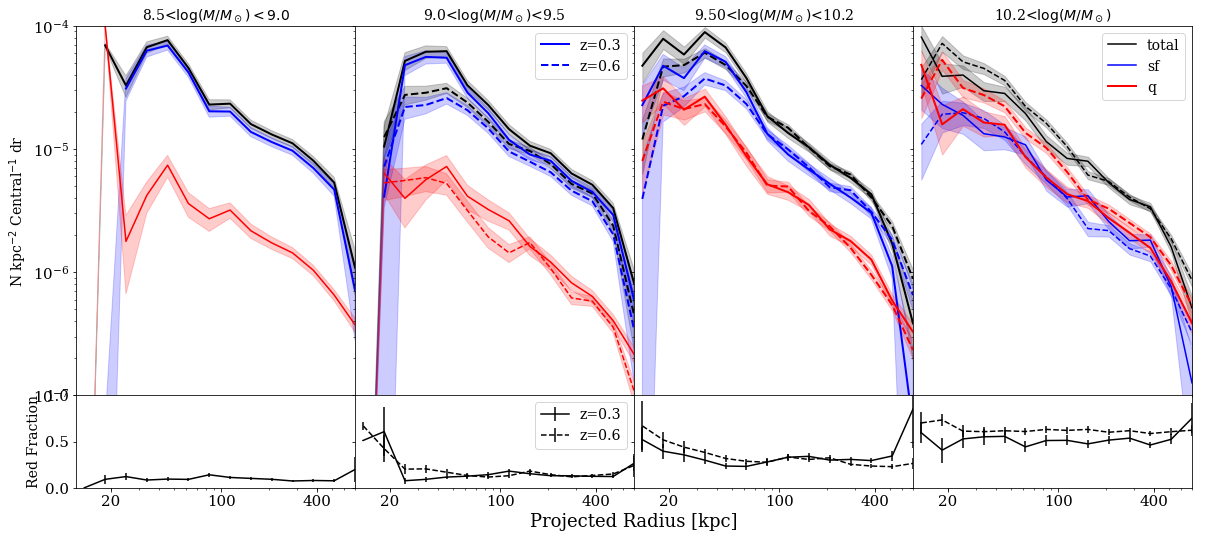

In [24]:

path = 'CUT_deep_catalogs/test_sfProb/'
bin_edges = np.load(path+'bin_edges.npy')

radial_3_sf_85 = combine_deep('all','ssf','8.5','9.0',0.3,path=path)
radial_3_sf_l = combine_deep('all','ssf','9.0','9.5',0.3,path=path)
radial_3_sf_m = combine_deep('all','ssf','9.5','10.2',0.3,path=path)
radial_3_sf_h = combine_deep('all','ssf','10.2','inf',0.3,path=path)
radial_3_q_85 = combine_deep('all','sq','8.5','9.0',0.3,path=path)
radial_3_q_l = combine_deep('all','sq','9.0','9.5',0.3,path=path)
radial_3_q_m = combine_deep('all','sq','9.5','10.2',0.3,path=path)
radial_3_q_h = combine_deep('all','sq','10.2','inf',0.3,path=path)

radial_6_sf_l = combine_deep('all','ssf','9.0','9.5',0.6,path=path)
radial_6_sf_m = combine_deep('all','ssf','9.5','10.2',0.6,path=path)
radial_6_sf_h = combine_deep('all','ssf','10.2','inf',0.6,path=path)
radial_6_q_l = combine_deep('all','sq','9.0','9.5',0.6,path=path)
radial_6_q_m = combine_deep('all','sq','9.5','10.2',0.6,path=path)
radial_6_q_h = combine_deep('all','sq','10.2','inf',0.6,path=path)

radial_3_85 = combine_results([radial_3_sf_85[0],radial_3_q_85[0]],[radial_3_sf_85[1],radial_3_q_85[1]])
radial_3_l = combine_results([radial_3_sf_l[0],radial_3_q_l[0]],[radial_3_sf_l[1],radial_3_q_l[1]])
radial_6_l = combine_results([radial_6_sf_l[0],radial_6_q_l[0]],[radial_6_sf_l[1],radial_6_q_l[1]])
radial_3_m = combine_results([radial_3_sf_m[0],radial_3_q_m[0]],[radial_3_sf_m[1],radial_3_q_m[1]])
radial_6_m = combine_results([radial_6_sf_m[0],radial_6_q_m[0]],[radial_6_sf_m[1],radial_6_q_m[1]])
radial_3_h = combine_results([radial_3_sf_h[0],radial_3_q_h[0]],[radial_3_sf_h[1],radial_3_q_h[1]])
radial_6_h = combine_results([radial_6_sf_h[0],radial_6_q_h[0]],[radial_6_sf_h[1],radial_6_q_h[1]])

redfrac_err_3_85 = red_frac_err(radial_3_q_85[0],radial_3_sf_85[0],radial_3_q_85[1],radial_3_sf_85[1])
redfrac_err_3_l = red_frac_err(radial_3_q_l[0],radial_3_sf_l[0],radial_3_q_l[1],radial_3_sf_l[1])
redfrac_err_6_l = red_frac_err(radial_6_q_l[0],radial_6_sf_l[0],radial_6_q_l[1],radial_6_sf_l[1])
redfrac_err_3_m = red_frac_err(radial_3_q_m[0],radial_3_sf_m[0],radial_3_q_m[1],radial_3_sf_m[1])
redfrac_err_6_m = red_frac_err(radial_6_q_m[0],radial_6_sf_m[0],radial_6_q_m[1],radial_6_sf_m[1])
redfrac_err_3_h = red_frac_err(radial_3_q_h[0],radial_3_sf_h[0],radial_3_q_h[1],radial_3_sf_h[1])
redfrac_err_6_h = red_frac_err(radial_6_q_h[0],radial_6_sf_h[0],radial_6_q_h[1],radial_6_sf_h[1])

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(2, 4, sharex=True, sharey='row', figsize = (20, 8.5),gridspec_kw={'height_ratios':[4,1]})
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)


#====================Radial Distribution ===================

# Total curves
axs[0][0].errorbar(bin_edges[1:], radial_3_85[0], yerr=None, fmt='k',linewidth=2)
axs[0][0].fill_between(bin_edges[1:],radial_3_85[0]+radial_3_85[1], 
                       aa(radial_3_85[0]-radial_3_85[1]), alpha=0.2, color='k')

axs[0][1].errorbar(bin_edges[1:], radial_3_l[0], yerr=None, fmt='k',linewidth=2)
axs[0][1].fill_between(bin_edges[1:],radial_3_l[0]+radial_3_l[1], 
                       aa(radial_3_l[0]-radial_3_l[1]), alpha=0.2, color='k')

axs[0][2].errorbar(bin_edges[1:], radial_3_m[0], yerr=None, fmt='k',linewidth=2)
axs[0][2].fill_between(bin_edges[1:],radial_3_m[0]+radial_3_m[1], 
                       aa(radial_3_m[0]-radial_3_m[1]), alpha=0.2, color='k')

axs[0][3].errorbar(bin_edges[1:], radial_3_h[0], yerr=None,fmt='k',label='total')
axs[0][3].fill_between(bin_edges[1:],radial_3_h[0]+radial_3_h[1], 
                       aa(radial_3_h[0]-radial_3_h[1]), alpha=0.2, color='k')

axs[0][1].errorbar(bin_edges[1:], radial_6_l[0], yerr=None, fmt='--k',linewidth=2)
axs[0][1].fill_between(bin_edges[1:],radial_6_l[0]+radial_6_l[1], 
                       aa(radial_6_l[0]-radial_6_l[1]), alpha=0.2, color='k')

axs[0][2].errorbar(bin_edges[1:], radial_6_m[0], yerr=None, fmt='--k',linewidth=2)
axs[0][2].fill_between(bin_edges[1:],radial_6_m[0]+radial_6_m[1], 
                       aa(radial_6_m[0]-radial_6_m[1]), alpha=0.2, color='k')

axs[0][3].errorbar(bin_edges[1:], radial_6_h[0], yerr=None,fmt='--k')
axs[0][3].fill_between(bin_edges[1:],radial_6_h[0]+radial_6_h[1], 
                       aa(radial_6_h[0]-radial_6_h[1]), alpha=0.2, color='k')

# Star Forming curves
axs[0][0].errorbar(bin_edges[1:], radial_3_sf_85[0], yerr=None, fmt='b',linewidth=2)
axs[0][0].fill_between(bin_edges[1:],radial_3_sf_85[0]+radial_3_sf_85[1], 
                       aa(radial_3_sf_85[0]-radial_3_sf_85[1]), alpha=0.2, color='b')
axs[0][0].set_xlabel('Projected Radius [kpc]', fontsize=14)
axs[0][0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=14)
axs[0][0].set_title(r'8.5<$\log(M/M_\odot)<9.0$',fontsize=14)

axs[0][1].errorbar(bin_edges[1:], radial_3_sf_l[0], yerr=None, fmt='b',label='z=0.3',linewidth=2)
axs[0][1].errorbar(bin_edges[1:], radial_6_sf_l[0], yerr=None, fmt='--b',label='z=0.6',linewidth=2)
axs[0][1].fill_between(bin_edges[1:],radial_3_sf_l[0]+radial_3_sf_l[1], 
                       aa(radial_3_sf_l[0]-radial_3_sf_l[1]), alpha=0.2, color='b')
axs[0][1].fill_between(bin_edges[1:],radial_6_sf_l[0]+radial_6_sf_l[1], 
                       aa(radial_6_sf_l[0]-radial_6_sf_l[1]), alpha=0.2, color='b')
axs[0][1].set_title(r'9.0<$\log(M/M_\odot)$<9.5',fontsize=14)

axs[0][2].errorbar(bin_edges[1:], radial_3_sf_m[0], yerr=None, fmt='b',linewidth=2)
axs[0][2].errorbar(bin_edges[1:], radial_6_sf_m[0], yerr=None, fmt='--b',linewidth=2)

axs[0][2].fill_between(bin_edges[1:],radial_3_sf_m[0]+radial_3_sf_m[1], 
                       aa(radial_3_sf_m[0]-radial_3_sf_m[1]), alpha=0.2, color='b')
axs[0][2].fill_between(bin_edges[1:],radial_6_sf_m[0]+radial_6_sf_m[1], 
                       aa(radial_6_sf_m[0]-radial_6_sf_m[1]), alpha=0.2, color='b')

axs[0][2].set_xlabel('Projected Radius [kpc]', fontsize=14)
axs[0][2].set_title(r'9.50<$\log(M/M_\odot)$<10.2',fontsize=14)

axs[0][3].errorbar(bin_edges[1:], radial_3_sf_h[0], yerr=None,fmt='b',label='sf')
axs[0][3].errorbar(bin_edges[1:], radial_6_sf_h[0], yerr=None,fmt='--b')
axs[0][3].fill_between(bin_edges[1:],radial_3_sf_h[0]+radial_3_sf_h[1], 
                       aa(radial_3_sf_h[0]-radial_3_sf_h[1]), alpha=0.2, color='b')
axs[0][3].fill_between(bin_edges[1:],radial_6_sf_h[0]+radial_6_sf_h[1], 
                       aa(radial_6_sf_h[0]-radial_6_sf_h[1]), alpha=0.2, color='b')
axs[0][3].set_title(r'10.2<$\log(M/M_\odot)$',fontsize=14)
axs[0][3].legend(fontsize=14)


# Quiescent Curves
axs[0][0].errorbar(bin_edges[1:], radial_3_q_85[0], yerr=None,fmt='r')
axs[0][0].fill_between(bin_edges[1:],radial_3_q_85[0]+radial_3_q_85[1], 
                       aa(radial_3_q_85[0]-radial_3_q_85[1]), alpha=0.2, color='r')

axs[0][1].errorbar(bin_edges[1:], radial_3_q_l[0], yerr=None,fmt='r')
axs[0][1].errorbar(bin_edges[1:], radial_6_q_l[0], yerr=None,fmt='--r')
axs[0][1].fill_between(bin_edges[1:],radial_3_q_l[0]+radial_3_q_l[1], 
                       aa(radial_3_q_l[0]-radial_3_q_l[1]), alpha=0.2, color='r')
axs[0][1].fill_between(bin_edges[1:],radial_6_q_l[0]+radial_6_q_l[1], 
                       aa(radial_6_q_l[0]-radial_6_q_l[1]), alpha=0.2, color='r')
axs[0][1].legend(fontsize=14)

axs[0][2].errorbar(bin_edges[1:], radial_3_q_m[0], yerr=None,fmt='r',linewidth=2)
axs[0][2].errorbar(bin_edges[1:], radial_6_q_m[0], yerr=None,fmt='--r',linewidth=2)
axs[0][2].fill_between(bin_edges[1:],radial_3_q_m[0]+radial_3_q_m[1], 
                       aa(radial_3_q_m[0]-radial_3_q_m[1]), alpha=0.2, color='r')
axs[0][2].fill_between(bin_edges[1:],radial_6_q_m[0]+radial_6_q_m[1], 
                       aa(radial_6_q_m[0]-radial_6_q_m[1]), alpha=0.2, color='r')

axs[0][3].errorbar(bin_edges[1:], radial_3_q_h[0], yerr=None,fmt='r',label='q',linewidth=2)
axs[0][3].errorbar(bin_edges[1:], radial_6_q_h[0], yerr=None,fmt='--r',linewidth=2)
axs[0][3].fill_between(bin_edges[1:],radial_3_q_h[0]+radial_3_q_h[1], 
                       aa(radial_3_q_h[0]-radial_3_q_h[1]), alpha=0.2, color='r')
axs[0][3].fill_between(bin_edges[1:],radial_6_q_h[0]+radial_6_q_h[1], 
                       aa(radial_6_q_h[0]-radial_6_q_h[1]), alpha=0.2, color='r')
axs[0][3].legend(fontsize=14)

axs[0][0].set_ylim([1e-7,1e-4])
axs[0][0].set_xlim([12,700])
axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')
axs[0][0].set_xticks([20, 100, 400])
axs[0][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#================Red Fraction========================
axs[1][0].errorbar(bin_edges[1:], radial_3_q_l[0]/(radial_3_sf_85[0]+radial_3_q_85[0]),fmt='k',yerr=redfrac_err_3_85)

axs[1][0].set_ylabel('Red Fraction',fontsize=14)

axs[1][1].errorbar(bin_edges[1:], radial_3_q_l[0]/(radial_3_sf_l[0]+radial_3_q_l[0]),fmt='k',yerr=redfrac_err_3_l,label='z=0.3')
axs[1][1].errorbar(bin_edges[1:], radial_6_q_l[0]/(radial_6_sf_l[0]+radial_6_q_l[0]),fmt='--k',yerr=redfrac_err_6_l,label='z=0.6')

axs[1][1].legend(fontsize=14)
axs[1][1].set_ylim([0,1])

axs[1][2].errorbar(bin_edges[1:], radial_3_q_m[0]/(radial_3_sf_m[0]+radial_3_q_m[0]),fmt='k',yerr=redfrac_err_3_m)
axs[1][2].errorbar(bin_edges[1:], radial_6_q_m[0]/(radial_6_sf_m[0]+radial_6_q_m[0]),fmt='--k',yerr=redfrac_err_6_m)

axs[1][3].errorbar(bin_edges[1:], radial_3_q_h[0]/(radial_3_sf_h[0]+radial_3_q_h[0]),fmt='k',yerr=redfrac_err_3_h)
axs[1][3].errorbar(bin_edges[1:], radial_6_q_h[0]/(radial_6_sf_h[0]+radial_6_q_h[0]),fmt='--k',yerr=redfrac_err_6_h)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.savefig('figures/splitting_mass_redfraction.png')
plt.show()

## With inside flag vs. without inside flag

2090.0
1708.0


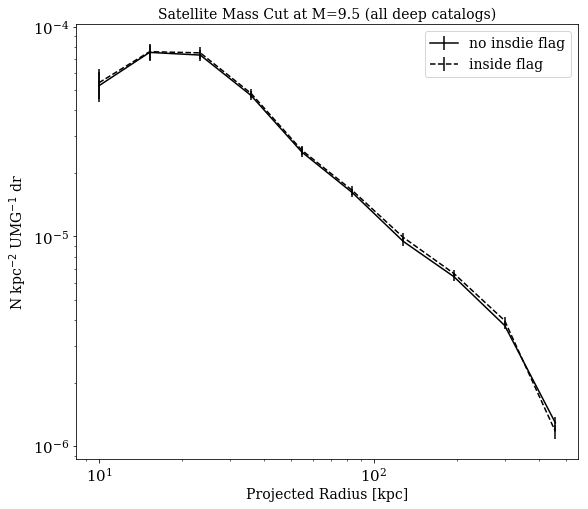

In [15]:
radial = combine_deep('all', 'all','9.5', 0.6, mode='count',path='CUT_deep_catalogs/test_inside_flag/',inside_flag=False)
radial_inside = combine_deep('all', 'all','9.5', 0.6, mode='count',path='CUT_deep_catalogs/test_inside_flag/',inside_flag=True)
bin_edges = np.load('CUT_deep_catalogs/test_inside_flag/bin_edges.npy')

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_edges[:-1],radial[0],radial[1],fmt='k',label='no insdie flag')
plt.errorbar(bin_edges[:-1],radial_inside[0],radial_inside[1],fmt='--k',label='inside flag')

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.title('Satellite Mass Cut at M=9.5 (all deep catalogs)', fontsize=14)
plt.savefig('figures/radial_count_completeness_correction.png')
plt.legend(fontsize=14)
plt.show()

## With mass complteness correction vs. without

2090.0
1708.0


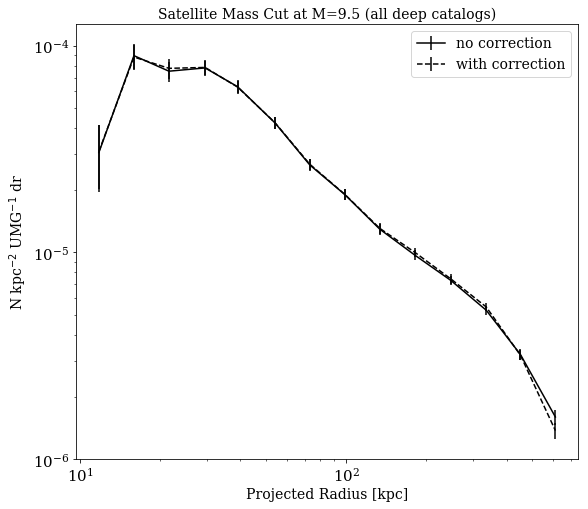

In [19]:
radial = combine_deep('all', 'all','9.5', 0.6, mode='count',path='CUT_deep_catalogs/completeness_correction/',inside_flag=False)
radial_c = combine_deep('all', 'all','9.5', 0.6, mode='count',path='CUT_deep_catalogs/completeness_correction/',inside_flag=True)
bin_centers = np.load('CUT_deep_catalogs/completeness_correction/bin_centers.npy')

fig = plt.figure(figsize=(9, 8))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
plt.errorbar(bin_centers,radial[0],radial[1],fmt='k',label='no correction')
plt.errorbar(bin_centers,radial_c[0],radial_c[1],fmt='--k',label='with correction')

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)
plt.xlabel('Projected Radius [kpc]', fontsize=14)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=14)
plt.title('Satellite Mass Cut at M=9.5 (all deep catalogs)', fontsize=14)
plt.savefig('figures/radial_count_completeness_correction.png')
plt.legend(fontsize=14)
plt.show()